# Investigating stage behavior

April-May 2020  
Albert Xu (albert.t.xu@gmail.com), Chen Xu (chen.xu@umassmed.edu) - UMass Medical School

This is an informal discussion on some technical aspects of collecting tilt series data for electron tomography.

#### When tilting the stage, there are mainly two problems that have to be addressed:
- the object moves out of focus (Z movement)
- the object moves out of the field of view (XY movement)

Recent papers discuss compensating stage movement by estimating parameters for linear models of Z and XY. Inuitively, a calibration routine would perform a tilt series to determine movement parameters that can be applied later. The assumption is that the stage behavior at the calibration spot mimics those at nearby target locations.

One underlying variable that is a concern for every tilt series is the error in refining eucentric height before starting. A major problem is that there is always an uncertainty, using either a beam tilt method or SerialEM's Eucentric Fine subroutine. This error in eucentric height has a large effect on both Z and XY movement, and could make separate calibration methods very challenging.

The goal of this investigation is to show how the stage behaves as height varies. 

The data was collected on the UMass Talos Arctica on April 22nd, and is similar to data from other days. The plots characterize how the sample moves for heights ranging +/- 2 microns away from eucentric height. After refining eucentricity in SerialEM either by beam tilt or by the Eucentric Fine subroutine, a bidirectional tilt series was done at the nominally eucentric height. Then the stage was moved down 2 microns and a tilt series was done for every 0.5 micron height increment. Measurements in Z were done by autofocusing, and XY movement was determined from image shift values by aligning successive tilt series frames.

Note: Stage X and Stage Y actually refer to SerialEM's specimen coordinates and not FEI stage coordinates.
- X = parallel to tilt axis
- Y = perpendicular to tilt axis

In [1]:
from matplotlib import pyplot as plt
import numpy as np

In [2]:
class TiltSeriesMovements:
    def __init__(self,
                 name,
                 initial_z,
                 tilt_angles,
                 defoci,
                 is_centering_checked,
                 image_shifts_x,
                 image_shifts_y,
                 pixel_shifts_x,
                 pixel_shifts_y,
                 stage_shifts_x,
                 stage_shifts_y,
                ):
        self.name = name
        self.initial_z = initial_z
        self.tilt_angles = tilt_angles
        self.defoci = defoci
        self.is_centering_checked = is_centering_checked
        self.image_shifts_x = image_shifts_x
        self.image_shifts_y = image_shifts_y
        self.pixel_shifts_x = pixel_shifts_x
        self.pixel_shifts_y = pixel_shifts_y
        self.stage_shifts_x = stage_shifts_x
        self.stage_shifts_y = stage_shifts_y
        

In [3]:
def get_tilt_series_data(logfile):

    #with open('tomotest_apr20/log.log') as f:
    with open(logfile) as f:
        log = f.read()

    # [(initial z, tilt_angles, defoci), ]
    tilt_series_data = []

    tilt_series_logs = log.split('<<<<')[1:]
    for tilt_series_log in tilt_series_logs:
        initial_z = None
        tilt_angles = []
        image_shifts_x = []
        image_shifts_y = []
        pixel_shifts_x = []
        pixel_shifts_y = []
        stage_shifts_x = []
        stage_shifts_y = []
        defoci = []

        lines = tilt_series_log.split('\n')
        name = lines[0].split()[0]
        for line in lines:
            if 'checked' in line:
                checked = bool(int(line.split()[2]))
            if 'Stage' in line:
                #print(line)
                initial_z = float(line.split()[3])
                #print(line.split()[3])
            if 'Measured defocus = ' in line:
                defocus = float(line.split()[3])
                defoci.append(defocus)
            if 'degrees' in line:
                tilt_angle = float(line.split()[0])
                tilt_angles.append(tilt_angle)
            if 'Image shift' in line:
                image_shift_x = float(line.split()[2])
                image_shift_y = float(line.split()[3])
                pixel_shift_x = float(line.split()[6])
                pixel_shift_y = float(line.split()[7])
                stage_shift_x = float(line.split()[12])
                stage_shift_y = float(line.split()[13])

                image_shifts_x.append(image_shift_x)
                image_shifts_y.append(image_shift_y)
                pixel_shifts_x.append(pixel_shift_x)
                pixel_shifts_y.append(pixel_shift_y)
                stage_shifts_x.append(stage_shift_x)
                stage_shifts_y.append(stage_shift_y)

        tilt_series_data.append(TiltSeriesMovements
                                (name,
                                 initial_z,
                                 tilt_angles,
                                 defoci,
                                 checked,
                                 image_shifts_x,
                                 image_shifts_y,
                                 pixel_shifts_x,
                                 pixel_shifts_y,
                                 stage_shifts_x,
                                 stage_shifts_y
                                )
                               )

    return tilt_series_data

In [4]:
tilt_series_data = get_tilt_series_data('tomotest_apr22/log.log')

# Z movement

Text(0.5, 1.0, 'Z focus measurements (um)')

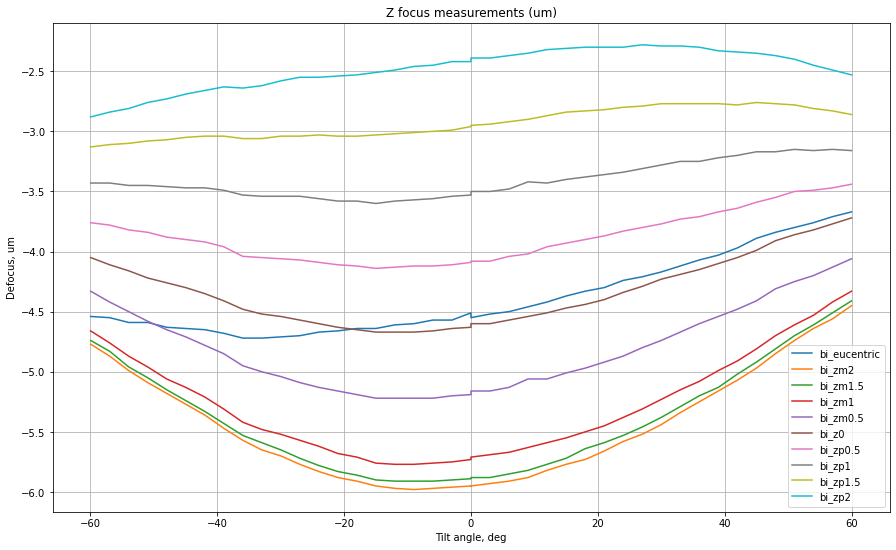

In [5]:
plt.figure(figsize=(15,9))
for ts in tilt_series_data:
    angles = ts.tilt_angles[:21][::-1] + ts.tilt_angles[21:]
    defoci = ts.defoci[:21][::-1] + ts.defoci[21:]
    plt.plot(angles, defoci, label=ts.name)
plt.legend()
plt.grid()
plt.xlabel('Tilt angle, deg')
plt.ylabel('Defocus, um')
plt.title('Z focus measurements (um)')

# Sine fit for Z

The data does not appear to be linear when far away from the nominally eucentric height, and is not strictly linear even at eucentric height. The cell below shows the least squares fit to a sine curve with the parameters being the amplitude and phase. However, the fit is only being done on 5 data points. This gives an idea of how well a calibration curve will fit a tilt series, since a calibration routine will only have a limited number of evenly spaced sample points.

2nd and 3rd order polynomial were also fit to these sample points, but Runge's phenomena was observed, so the curves didn't fit well at high tilt angles.

bi_eucentric
	sample angles: [-38.94, -20.97, 0.0, 20.98, 38.96]
	sample defoci: [-4.68, -4.66, -4.51, -4.3, -4.03]
	fitted params: [  0.89724265  -3.78514568 -55.09543752]
bi_zm2
	sample angles: [-38.94, -20.96, 0.01, 20.98, 38.96]
	sample defoci: [-5.47, -5.88, -5.95, -5.66, -5.16]
	fitted params: [ -2.89032017  -3.07774715 455.17981883]
bi_zm1.5
	sample angles: [-38.93, -20.96, 0.01, 20.98, 38.96]
	sample defoci: [-5.43, -5.83, -5.89, -5.59, -5.13]
	fitted params: [-2.76126968 -3.14239896 95.43714457]
bi_zm1
	sample angles: [-38.94, -20.97, 0.0, 20.99, 38.97]
	sample defoci: [-5.31, -5.68, -5.73, -5.45, -4.99]
	fitted params: [  -2.64102056   -3.10821359 -264.12803279]
bi_zm0.5
	sample angles: [-38.93, -20.97, 0.01, 20.98, 38.97]
	sample defoci: [-4.85, -5.16, -5.19, -4.92, -4.54]
	fitted params: [  2.23655121  -2.9678717  276.87286865]
bi_z0
	sample angles: [-38.93, -20.97, 0.01, 20.98, 38.96]
	sample defoci: [-4.41, -4.63, -4.63, -4.4, -4.1]
	fitted params: [  1.70016545  -2.94839

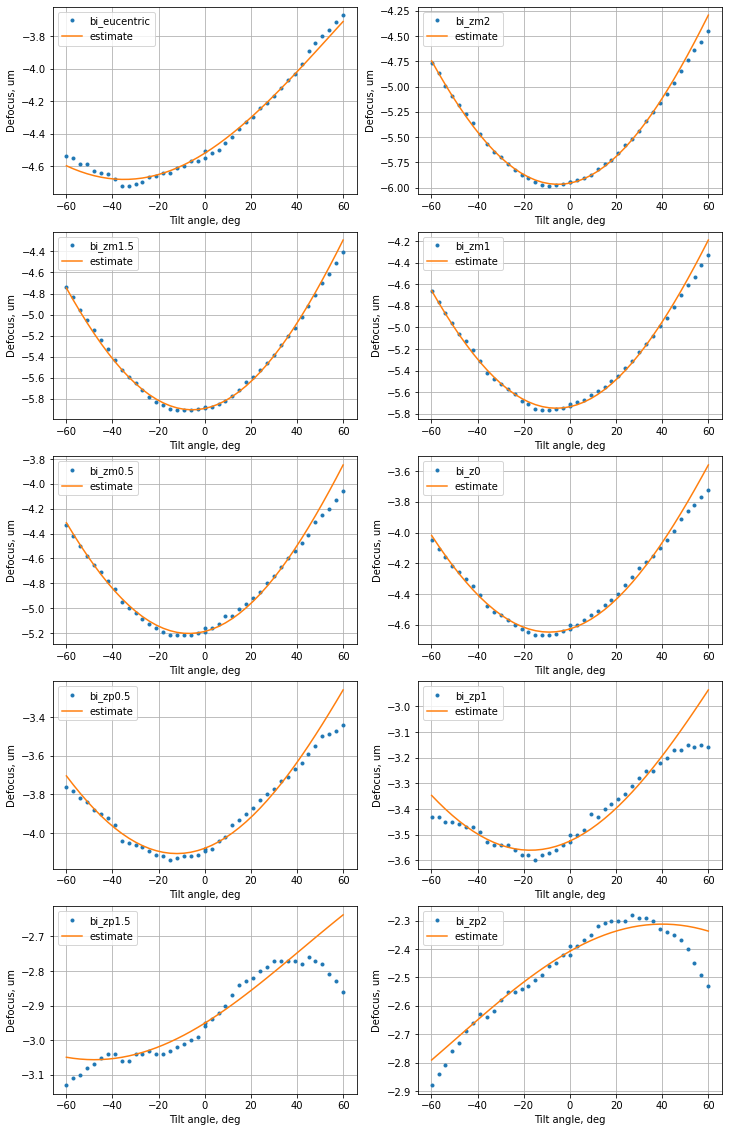

In [6]:
from scipy import optimize

def sin_deg(angle, a, b, phase):
    return a * np.sin((angle + phase) * 2*np.pi / 360) + b

sample_indices = [7, 13, 20, 28, 34]

plt.figure(figsize=(12,20))

for ts_index in range(len(tilt_series_data)):
    ts = tilt_series_data[ts_index]
    angles = ts.tilt_angles[:21][::-1] + ts.tilt_angles[21:]
    defoci = ts.defoci[:21][::-1] + ts.defoci[21:]
    
    sample_angles = [angles[i] for i in sample_indices]
    sample_defoci = [defoci[i] for i in sample_indices]
    print(ts.name)
    print('\tsample angles: ', end='')
    print(sample_angles)
    print('\tsample defoci: ', end='')
    print(sample_defoci)
    params, covariance = optimize.curve_fit(sin_deg, sample_angles, sample_defoci)
    print('\tfitted params: ', end='')
    print(params)
    estimates = sin_deg(angles, *params)
    
    plt.subplot(5,2,ts_index+1)
    plt.plot(angles, defoci, '.', label=ts.name)
    plt.plot(angles, estimates, '-', label='estimate')
    plt.legend()
    plt.grid()
    plt.xlabel('Tilt angle, deg')
    plt.ylabel('Defocus, um')

# Stage X

Text(0, 0.5, 'X movement from zero deg tilt, um')

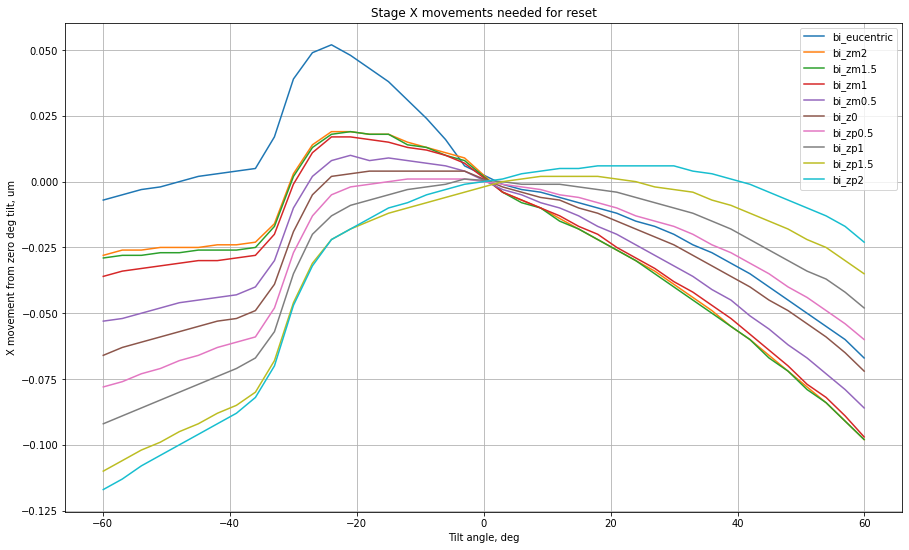

In [7]:
plt.figure(figsize=(15,9))
for ts in tilt_series_data:
    angles = [ts.tilt_angles[i] for i in range(len(ts.tilt_angles)) if i != 0 and i != 21]
    negative_angles = angles[:20][::-1]
    positive_angles = angles[20:]
    angles = negative_angles + positive_angles
    negative_stage_x = ts.stage_shifts_x[:20][::-1]
    positive_stage_x = ts.stage_shifts_x[20:]
    stage_x = negative_stage_x + positive_stage_x
    plt.plot(angles, stage_x, label=ts.name)
plt.legend()
plt.grid()
plt.title('Stage X movements needed for reset')
plt.xlabel('Tilt angle, deg')
plt.ylabel('X movement from zero deg tilt, um')

The movement parallel to the tilt axis is very small, so we no compensation is needed.

# Stage Y

Text(0.5, 1.0, 'Stage Y movements needed for reset')

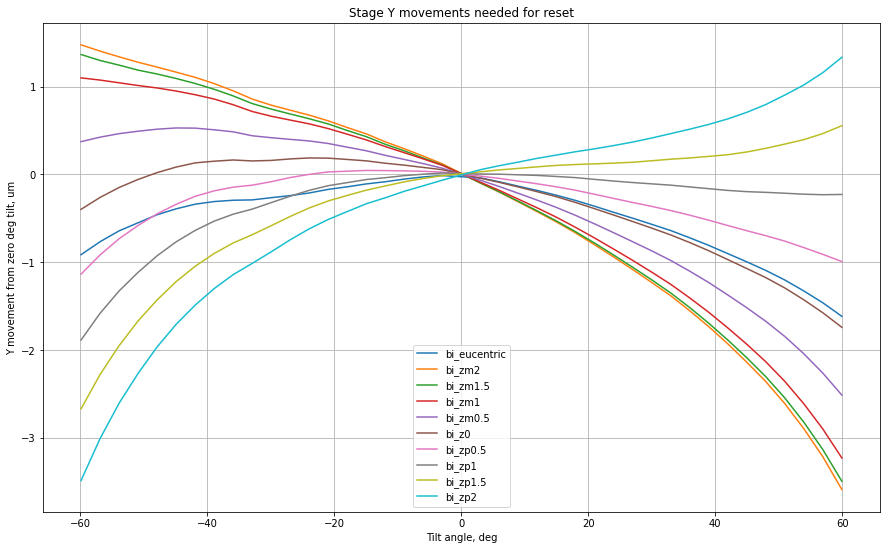

In [8]:
plt.figure(figsize=(15,9))
for ts in tilt_series_data[:]:
    angles = [ts.tilt_angles[i] for i in range(len(ts.tilt_angles)) if i != 0 and i != 21]
    negative_angles = angles[:20][::-1]
    positive_angles = angles[20:]
    angles = negative_angles + positive_angles
    negative_stage_y = ts.stage_shifts_y[:20][::-1]
    positive_stage_y = ts.stage_shifts_y[20:]
    stage_y = negative_stage_y + positive_stage_y
    plt.plot(angles, stage_y, label=ts.name)
plt.legend()
plt.grid()
plt.xlabel('Tilt angle, deg')
plt.ylabel('Y movement from zero deg tilt, um')
plt.title('Stage Y movements needed for reset')

# Cubic fit for Y

The movement perpendicular to the tilt axis needs to be compensated. Otherwise, the sample would move somewhere around 1-2 microns away on both sides and would go out of the field of view for medium-high magnifications.

Important note: calibrations for Y are not used in FastTomo. More in discussion at the end.

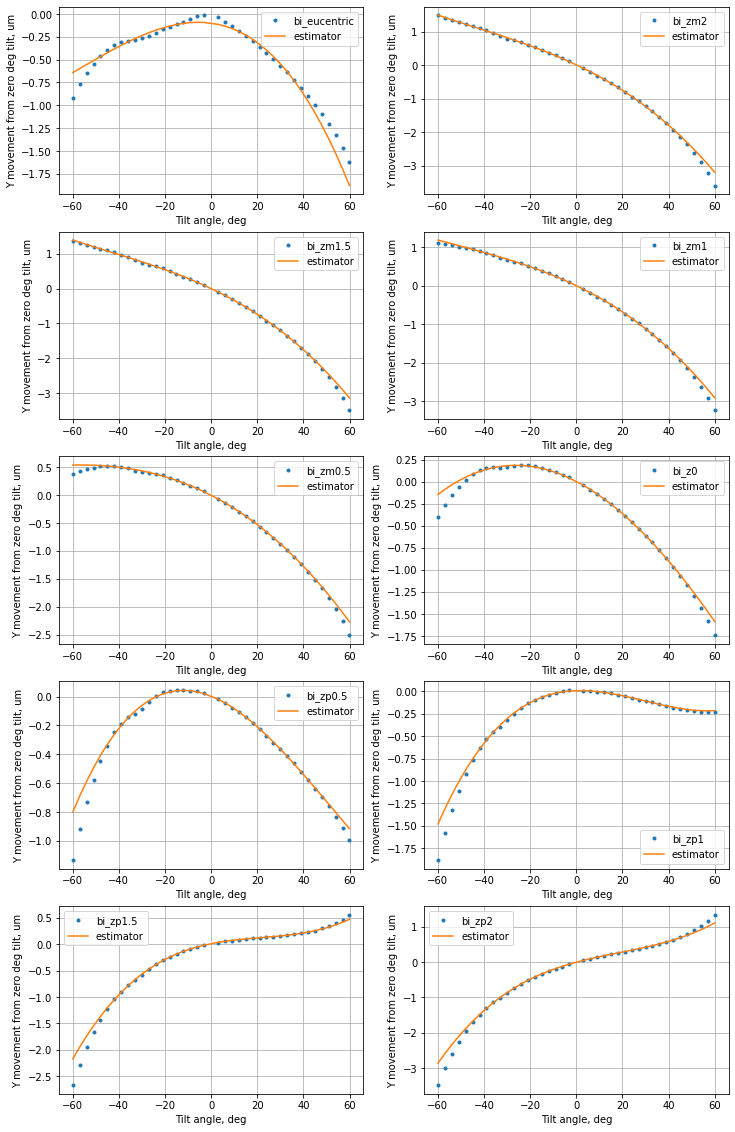

In [9]:
degree_fit = 3
sample_indices = [7, 9, 11, 13, 15, 20, 24, 26, 28, 30, 32]

plt.figure(figsize=(12,20))

for ts_index in range(len(tilt_series_data)):
    ts = tilt_series_data[ts_index]
    angles = [ts.tilt_angles[i] for i in range(len(ts.tilt_angles)) if i != 0 and i != 21]
    negative_angles = angles[:20][::-1]
    positive_angles = angles[20:]
    angles = negative_angles + positive_angles
    negative_stage_y = ts.stage_shifts_y[:20][::-1]
    positive_stage_y = ts.stage_shifts_y[20:]
    stage_y = negative_stage_y + positive_stage_y
    
    sample_angles = [angles[i] for i in sample_indices]
    sample_y = [stage_y[i] for i in sample_indices]
    params = np.polyfit(sample_angles, sample_y, degree_fit)
    estimator = np.poly1d(params)
    
    plt.subplot(5,2,ts_index+1)
    plt.plot(angles, stage_y, '.', label=ts.name)
    plt.plot(angles, estimator(angles), label='estimator')
    plt.grid()
    plt.legend()
    plt.xlabel('Tilt angle, deg')
    plt.ylabel('Y movement from zero deg tilt, um')

# Z vs Stage Y

Just for those curious, here is Z plotted against Y.

Text(0, 0.5, 'Defocus, um')

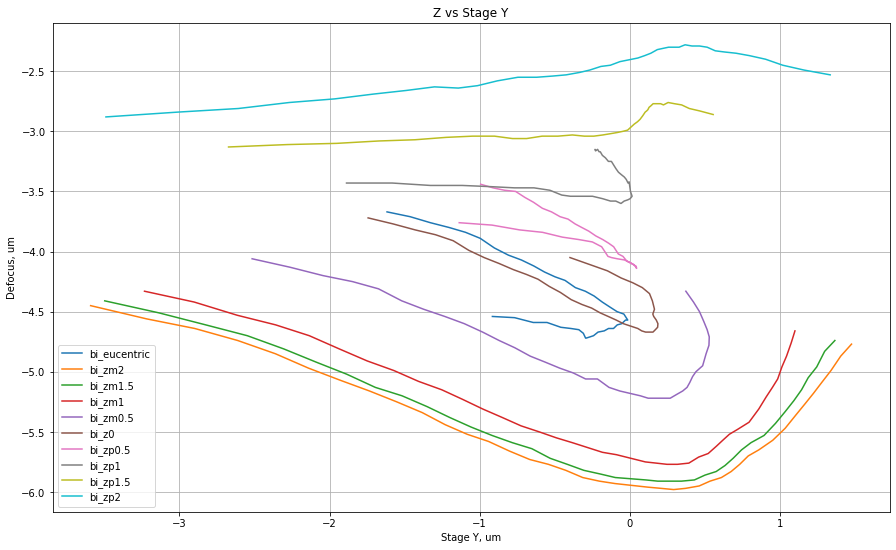

In [10]:
plt.figure(figsize=(15,9))
for ts in tilt_series_data:
    defoci = [ts.defoci[i] for i in range(len(ts.defoci)) if i != 0 and i != 21]
    negative_angle_defoci = defoci[:20][::-1]
    positive_angle_defoci = defoci[20:]
    defoci = negative_angle_defoci + positive_angle_defoci
    negative_stage_y = ts.stage_shifts_y[:20][::-1]
    positive_stage_y = ts.stage_shifts_y[20:]
    stage_y = negative_stage_y + positive_stage_y
    plt.plot(stage_y, defoci, label=ts.name)
plt.legend()
plt.grid()
plt.title('Z vs Stage Y')
plt.xlabel('Stage Y, um')
plt.ylabel('Defocus, um')

# Z vs Stage X

And Z vs X, for completeness.

Text(0.5, 1.0, 'Z vs Stage X')

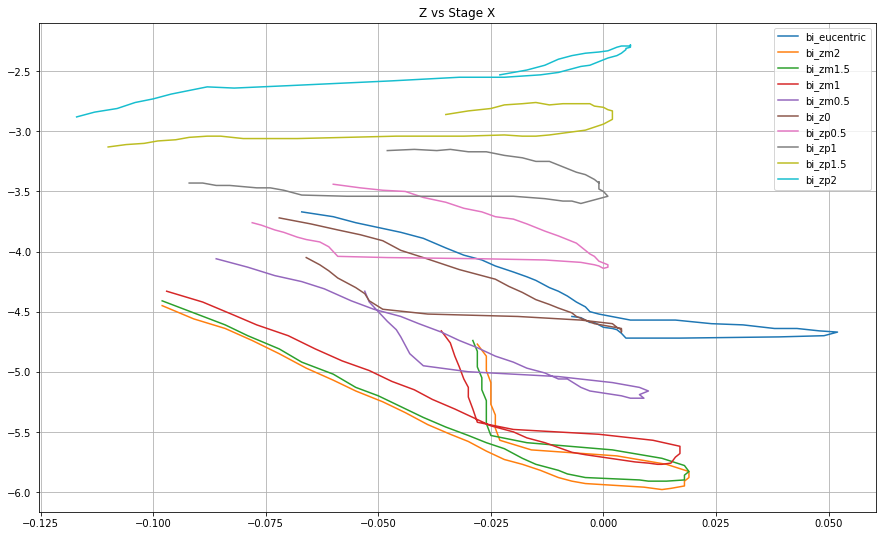

In [11]:
plt.figure(figsize=(15,9))
for ts in tilt_series_data:
    defoci = [ts.defoci[i] for i in range(len(ts.defoci)) if i != 0 and i != 21]
    negative_angle_defoci = defoci[:20][::-1]
    positive_angle_defoci = defoci[20:]
    defoci = negative_angle_defoci + positive_angle_defoci
    negative_stage_x = ts.stage_shifts_x[:20][::-1]
    positive_stage_x = ts.stage_shifts_x[20:]
    stage_x = negative_stage_x + positive_stage_x
    plt.plot(stage_x, defoci, label=ts.name)
plt.legend()
plt.grid()
plt.title('Z vs Stage X')

# Discussion

### Why Y calibrations are not used in FastTomo
At first we tried fitting the Y curves to a 3rd-order polynomial. This worked for low tilt angles, but the sample moved about 1-1.5 um away when getting to high tilts.

Another idea we tried was to use the correlation between successive frames to continuously update the polynomial prediction. This actually worked better when a 2nd-order polynomial was used. However, the sample still moved away at high angles, but not as far.

It turns out that simply aligning the image shift to the current frame works best, and so that is what is done in FastTomo. We welcome anyone to try the script and give feedback.

# References

1. Chreifi, G., Chen, S., Metskas, L. A., Kaplan, M., & Jensen, G. J. (2019). Rapid tilt-series acquisition for electron cryotomography. Journal of Structural Biology, 205(2), 163–169. doi: 10.1016/j.jsb.2018.12.008

2. Eisenstein, F., Danev, R., & Pilhofer, M. (2019). Improved applicability and robustness of fast cryo-electron tomography data acquisition. Journal of Structural Biology, 208(2), 107–114. doi: 10.1016/j.jsb.2019.08.006